<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Lendo-os-Dados" data-toc-modified-id="Lendo-os-Dados-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Lendo os Dados</a></span></li><li><span><a href="#Plotando-os-Dados" data-toc-modified-id="Plotando-os-Dados-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plotando os Dados</a></span></li><li><span><a href="#Função-Custo-(sem-regularização)" data-toc-modified-id="Função-Custo-(sem-regularização)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Função Custo (sem regularização)</a></span></li><li><span><a href="#Função-Custo-(com-regularização)" data-toc-modified-id="Função-Custo-(com-regularização)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Função Custo (com regularização)</a></span></li><li><span><a href="#Função-Custo-Geral" data-toc-modified-id="Função-Custo-Geral-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Função Custo Geral</a></span></li><li><span><a href="#Back-Propagation" data-toc-modified-id="Back-Propagation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Back Propagation</a></span></li><li><span><a href="#Sigmoid-Gradient" data-toc-modified-id="Sigmoid-Gradient-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Sigmoid Gradient</a></span></li></ul></div>

Este notebook tem por objetivo armazenar cálculos e tentativas de resolução do exercício 4 de Machine Learning do curso de Andrew Ng (Stamford).

## Lendo os Dados

In [1]:
% Configurações iniciais
input_layer_size = 400;
hidden_layer_size = 25; 
num_labels = 10; 

Explicando as variáveis acima:
    - input_layer_size: as imagens possuem dimensões 20x20, logo, tratam-se de 400 features;
    - hidden_layer_size: será utilizada uma única camada oculta com 25 unidades;
    - num_labels: como o objetivo é classificar dígitos de 0 a 9, tem-se 10 labels.

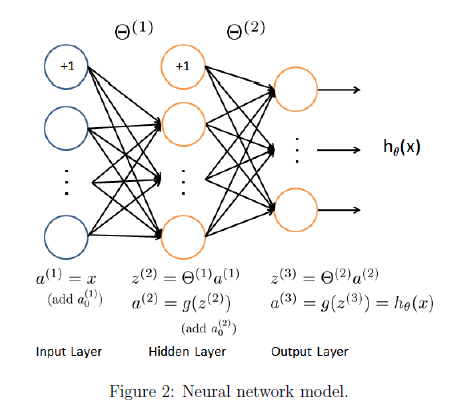

In [2]:
% Lendo o arquivo e verificando resultado
load('ex4data1.mat');

A leitura do arquivo acima retorna duas variávels,  ```X``` e ```y```, indicando, respectivamente as features e o target.

In [3]:
% Resultado da leitura
size(X)
size(y)

ans =

   5000    400

ans =

   5000      1



In [4]:
% Comunicando formalmente
fprintf('O dataset lido possui %d registros e %d features (%d x %d pixels)\n', ...
        size(X, 1), size(X, 2), sqrt(size(X, 2)), sqrt(size(X, 2)))

O dataset lido possui 5000 registros e 400 features (20 x 20 pixels)


## Plotando os Dados

Uma função específica para plotagem dos dados já foi definida e disponibilizada nos arquivos do Exercício 4. Com ```displayData()```, basta passar os dados de entrada como parâmetros para retornar um grid 10x10 com dígitos aleatórios.

In [5]:
% Implementando função para plotagem dos dados

function [h, display_array] = displayData(X, example_width)

%DISPLAYDATA Display 2D data in a nice grid
%   [h, display_array] = DISPLAYDATA(X, example_width) displays 2D data
%   stored in X in a nice grid. It returns the figure handle h and the 
%   displayed array if requested.

% Set example_width automatically if not passed in
if ~exist('example_width', 'var') || isempty(example_width) 
	example_width = round(sqrt(size(X, 2)));
end

% Gray Image
colormap(gray);

% Compute rows, cols
[m n] = size(X);
example_height = (n / example_width);

% Compute number of items to display
display_rows = floor(sqrt(m));
display_cols = ceil(m / display_rows);

% Between images padding
pad = 1;

% Setup blank display
display_array = - ones(pad + display_rows * (example_height + pad), ...
                       pad + display_cols * (example_width + pad));

% Copy each example into a patch on the display array
curr_ex = 1;
for j = 1:display_rows
	for i = 1:display_cols
		if curr_ex > m, 
			break; 
		end
		% Copy the patch
		
		% Get the max value of the patch
		max_val = max(abs(X(curr_ex, :)));
		display_array(pad + (j - 1) * (example_height + pad) + (1:example_height), ...
		              pad + (i - 1) * (example_width + pad) + (1:example_width)) = ...
						reshape(X(curr_ex, :), example_height, example_width) / max_val;
		curr_ex = curr_ex + 1;
	end
	if curr_ex > m, 
		break; 
	end
end

% Display Image
h = imagesc(display_array, [-1 1]);

% Do not show axis
axis image off

drawnow;

end

In [6]:
% Retornando a quantidade de linhas do conjunto de dados
rows = size(X, 1);

% Retornando uma matriz aleatória de acordo com "rows"
sel = randperm(rows);

% Filtrando os 100 primeiros elementos dessa seleção aleatória
sel = sel(1:100);

% Verificando dimensões da seleção final
dim_sel = size(sel)

dim_sel =

     1   100



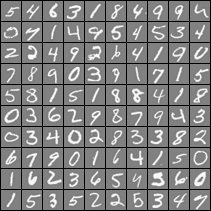

In [7]:
% Chamando função
displayData(X(sel, :));

## Função Custo (sem regularização)

O cálculo da função custo será realizado a partir de parâmetros previamente salvos e retornados em duas variáveis Theta1 e Theta2. A célula abaixo retorna os parâmetros.

In [8]:
% Lendo parâmetros já salvos
load('ex4weights.mat')

In [9]:
% Verificando resultados
fprintf('Dimensões de Theta1: %d linhas e %d colunas\n', size(Theta1, 1), size(Theta1, 2))
fprintf('Dimensões de Theta2: %d linhas e %d colunas\n', size(Theta2, 1), size(Theta2, 2))

Dimensões de Theta1: 25 linhas e 401 colunas
Dimensões de Theta2: 10 linhas e 26 colunas


A primeira matriz de parâmetros, ```Theta1```, possui dimensões 25x401, indicando que saímos de 400 unidades na camada de input (+1 bias), para 25 unidades na próxima camada (oculta, no caso).

Já a segunda matriz de parâmetros, ```Theta2```, com dimensões 10x26, confirma que a camada intermediária (oculta) possui 25 unidades (+1 bias) e que, na camada de output, temos 10 unidades (representando os 10 labels dos 10 dígitos).

Antes de calcular a função custo, é importante vetorizar a matriz de parâmetros

In [10]:
% Criando um único vetor através da união das matrizes de parâmetros
nn_params = [Theta1(:); Theta2(:)];

% Retornando novamente os parâmetros em forma de matrizes
Theta1_unrolled = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), ...
                 hidden_layer_size, (input_layer_size + 1));

Theta2_unrolled = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), ...
                 num_labels, (hidden_layer_size + 1));
                 
% Quantidade de linhas
m = size(X, 1);

In [11]:
% Verificando
dim_nn_params = size(nn_params)

dim_nn_params =

   10285       1



A conta é simples: 25x401 da primeira matriz Theta1 + 26x10 da segunda matriz Theta2

In [12]:
% Dimensões das matrizes "unrolled"
dim_Theta1_unrolled = size(Theta1_unrolled)
dim_Theta2_unrolled = size(Theta2_unrolled)

dim_Theta1_unrolled =

    25   401

dim_Theta2_unrolled =

   10   26



Ok! Até o momento, as operações deram certo e os cálculos estão confiáveis. Ainda antes de calcular a função custo, é preciso mapear a saida h_theta e, para tal, é necessário definir uma função para calcular a ```sigmoide```.

In [13]:
% Definindo função para cálculo sigmoide
function g = sigmoid(z)

    g = 1.0 ./ (1.0 + exp(-z));
    
end

Para que as multiplicações possam ser realizadas, é importante adicionar uma coluna ```bias``` no dataset.

In [14]:
% Adicionando termo bias em X e multiplicando
X_bias = [ones(m, 1) X];

% Verificando dimensões
fprintf('Dimensões X_train (pré-bias): %d x %d\n', size(X, 1), size(X, 2))
fprintf('Dimensões X_bias (pós-bias): %d x %d\n', size(X_bias, 1), size(X_bias, 2))

Dimensões X_train (pré-bias): 5000 x 400
Dimensões X_bias (pós-bias): 5000 x 401


In [15]:
% Função de ativação da camada 2
z2 = X_bias * Theta1';
a2 = sigmoid(z2);
dim_a2 = size(a2)

dim_a2 =

   5000     25



In [16]:
% O próximo passo é adicionar o termo bias na matriz a
a2 = [ones(m, 1) a2];
size(a2)

ans =

   5000     26



In [17]:
% Calculando z_3 última função de ativação a_3 = h_theta
z3 = a2 * Theta2';
dim_z3 = size(z3)
h_theta = sigmoid(z3);
dim_htheta = size(h_theta)

dim_z3 =

   5000     10

dim_htheta =

   5000     10



Calculando o fluxo completo em uma única linha

In [18]:
% Função de ativação da camada 2 (hidden)
a1 = X_bias;
a2 = sigmoid(a1 * Theta1');
a2 = [ones(m, 1) a2];

% Função de ativação da camada 3 (output)
a3 = sigmoid(a2 * Theta2');
h_theta = a3;

In [19]:
% Verificando dimensões
fprintf('A função hypothesis h_theta possui %d linhas e %d colunas\n', ...
                                size(h_theta, 1), size(h_theta, 2));

A função hypothesis h_theta possui 5000 linhas e 10 colunas


Com a função theta ```h_theta``` em mãos, é possível calcular a função de custo ```J(theta)```;

Antes de mais nada, é necessário transformar o vetor ```y``` (target de 5000 linhas e 1 coluna -> indicando, em cada linha, o respectivo dígito) em uma matriz 5000 x 10, vetorizando o output (lembrar do exemplo do avião, pedestre, carro, etc...)

dígito = 5
    - y = [0; 0; 0; 0; 0; 1; 0; 0; 0; 0]

In [20]:
% Primeiro passo - Criando matriz de labels
y_matrix = eye(num_labels) (y, :)

y_matrix =

   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0

   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0

   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   1
   0   0   0   0

   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0

   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0
   1   0   0   0

   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0

   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0

   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0
   0   1   0   0

   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0

   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0   0   0   0   0   0   0
   0   0   1   0

   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1

   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1

   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0
   0   0   0   1

   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0

   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0
   0   0   0   0

   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0

   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0

   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   1   0   0   0   0
   0   0   0   0

   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0

   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   1   0   0   0
   0   0   0   0

   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0

   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0   0   0   0   1   0   0
   0   0   0   0

In [21]:
# Calculando custo sem regularização
unreg_J = sum(sum((-y_matrix .* log(h_theta)) - ((1 - y_matrix) .* log(1 - h_theta)))) / m

Detalhando cálculo...

In [22]:
# Primeira operação
op1 = -y_matrix .* log(h_theta);
size(op1)
op1

ans =

   5000     10

op1 =

 Columns 1 through 8:

   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.0

   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.000

   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.000

   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.000

   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.000

   1.00507   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.02602   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.01445   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.06244   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.11759   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.02379   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.04854   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.04393   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.01575   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.02363   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.04371   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.03525   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   4.19372   0.00000   0.000

   0.01751   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.02171   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.13345   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.14326   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.02757   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.07497   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.03461   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.02981   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.06364   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.18351   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.06540   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.01465   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.02181   0.00000   0.000

   0.01337   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.01405   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.01774   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.01960   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.02313   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.04926   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.04195   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.01497   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.05297   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.03879   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.12255   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.89620   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.01477   0.00000   0.000

   0.18223   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.25497   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.31834   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.20321   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.44995   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.02199   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.32312   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.02952   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.01249   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.03999   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.01932   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.03506   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.04059   0.00000   0.000

   0.05361   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.01512   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.03832   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.07363   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.02461   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.02132   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.16404   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.01895   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.01539   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00949   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.02650   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.04576   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.05862   0.00000   0.000

   0.00000   0.02037   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00058   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.01330   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00345   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.01601   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00151   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.76129   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.98221   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00129   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00103   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00167   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.05228   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00283   0.000

   0.00000   0.00482   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00348   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.05537   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00193   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.87044   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.02552   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.06490   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.25807   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.06038   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.61441   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.38464   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00775   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.19375   0.000

   0.00000   0.00480   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.03215   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00263   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00414   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00247   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.02937   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00429   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00913   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.41591   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00228   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00188   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.01042   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.01155   0.000

   0.00000   0.19178   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00970   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.02167   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.18439   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00606   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00349   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.35150   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.04265   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00233   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00150   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00619   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00123   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00348   0.000

   0.00000   0.01714   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00522   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00590   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.04576   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.01140   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.02461   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.01254   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00741   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.08442   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.01327   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.26897   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00642   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.12000   0.000

   0.00000   0.00000   0.00314   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.02620   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.01143   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.01320   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.01286   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.01065   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.01742   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.06190   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00582   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.04520   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00601   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00654   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.015

   0.00000   0.00000   0.01213   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.11066   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00587   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00180   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.10629   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.08226   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.08330   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.03763   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.01844   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.20258   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.08512   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.12092   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.017

   0.00000   0.00000   0.01937   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.04814   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00456   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.05873   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.03419   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.01803   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.06936   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.16952   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.02436   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00535   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.05428   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.27276   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.097

   0.00000   0.00000   0.40049   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.02093   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.01550   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.04282   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.02388   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00517   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.16579   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.01045   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.10069   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.02468   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.22252   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.15559   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.053

   0.00000   0.00000   0.25118   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.04566   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.09979   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.14218   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.03675   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.00558   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.13070   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.01697   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.34074   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.49853   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.02901   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.01275   0.00000   0.00000   0.00000   0.00000   0.00000
   0.00000   0.00000   0.100

   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   

   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   

   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000
   0.00000   0.00000


In [23]:
# Segunda operação
op2 = (1 - y_matrix) .* log(1 - h_theta);
size(op2)
op2

  -0.00181  -0.00000  -0.01652  -0.00013  -0.00067  -0.00008  -0.00067  -0.54074
  -0.02792  -0.00000  -0.00309  -0.00110  -0.00063  -0.00227  -0.00015  -0.00286
  -0.00061  -0.00000  -0.00466  -0.00054  -0.00023  -0.00551  -0.00032  -0.00056
  -0.00026  -0.00000  -0.01828  -0.00034  -0.00119  -0.00549  -0.00008  -0.01472
  -0.00041  -0.00000  -0.00290  -0.00199  -0.00338  -0.00079  -0.00012  -0.00959
  -0.00128  -0.00000  -0.02599  -0.00254  -0.00032  -0.00210  -0.00008  -0.00591
  -0.00152  -0.00000  -0.01799  -0.00060  -0.00086  -0.00092  -0.00003  -0.01244
  -0.00045  -0.00000  -0.02295  -0.00005  -0.01881  -0.00009  -0.00327  -0.00032
  -0.00066  -0.00000  -0.00125  -0.00816  -0.00204  -0.02371  -0.00002  -0.00650
  -0.00777  -0.00000  -0.02201  -0.00134  -0.00021  -0.00080  -0.00017  -0.00345
  -0.00009  -0.00000  -0.00222  -0.00034  -0.05766  -0.48670  -0.00030  -0.00006
  -0.00060  -0.00000  -0.11125  -0.00263  -0.00189  -0.00009  -0.00023  -0.00023
  -0.00079  -0.00000  -0.004

  -0.00117  -0.00000  -0.01690  -0.00081  -0.00016  -0.00103  -0.00007  -0.00852
  -0.00096  -0.00000  -0.00636  -0.00293  -0.00100  -0.00149  -0.00004  -0.00421
  -0.00638  -0.00000  -0.02224  -0.01086  -0.00028  -0.00214  -0.00012  -0.00133
  -0.00416  -0.00000  -0.03134  -0.00535  -0.00140  -0.00074  -0.00002  -0.00235
  -0.00045  -0.00000  -0.01032  -0.00039  -0.00011  -0.01903  -0.00100  -0.00083
  -0.00112  -0.00000  -0.01080  -0.00231  -0.00019  -0.01087  -0.00020  -0.00234
  -0.00114  -0.00000  -0.02011  -0.00055  -0.00911  -0.00566  -0.00004  -0.01351
  -0.00038  -0.00000  -0.00021  -0.33616  -0.00010  -0.02625  -0.00062  -0.00060
  -0.00953  -0.00000  -0.11878  -0.00006  -0.00001  -0.00096  -0.01291  -0.09991
  -0.00019  -0.00000  -0.00385  -0.00189  -0.00192  -0.06981  -0.00066  -0.00049
  -0.00018  -0.00000  -0.03193  -0.00063  -0.00014  -0.01378  -0.00044  -0.00336
  -0.00021  -0.00000  -0.00094  -0.00273  -0.00138  -0.01438  -0.00303  -0.00277
  -0.00064  -0.00000  -0.000

  -0.02161  -0.00000  -0.11896  -0.00004  -0.00001  -0.00339  -0.02437  -0.02134
  -0.00197  -0.00000  -0.00202  -0.00015  -0.00059  -0.00713  -0.00010  -0.00678
  -0.00343  -0.00000  -0.00005  -0.00004  -0.00112  -0.01468  -0.00145  -0.05657
  -0.00029  -0.00000  -0.00831  -0.01854  -0.00042  -0.01552  -0.00216  -0.00088
  -0.00045  -0.00000  -0.02420  -0.00008  -0.00114  -0.00036  -0.00064  -0.00298
  -0.92575  -0.00000  -0.03639  -0.00000  -0.07154  -0.00911  -0.04443  -0.00443
  -0.00004  -0.00000  -0.00032  -0.00045  -0.00389  -0.00129  -0.00136  -0.00254
  -0.00052  -0.00000  -0.01915  -0.00028  -0.00507  -0.00277  -0.00007  -0.01262
  -0.03284  -0.00000  -0.09161  -0.00011  -0.01095  -0.01761  -0.00026  -0.00355
  -0.00767  -0.00000  -0.06379  -0.00016  -0.00006  -0.00006  -0.00879  -0.01115
  -0.00147  -0.00000  -0.00141  -0.04234  -0.00046  -0.07844  -0.00154  -0.00066
  -0.00021  -0.00000  -0.03949  -0.00134  -0.00004  -0.06591  -0.00051  -0.00167
  -0.09290  -0.00000  -0.027

  -0.00852  -0.00399  -0.00000  -0.00004  -0.00741  -0.00006  -0.00036  -0.00391
  -0.00086  -0.00120  -0.00000  -0.00049  -0.00161  -0.00000  -0.01717  -0.01423
  -0.00174  -0.00027  -0.00000  -0.00080  -0.00537  -0.00001  -0.00093  -0.04819
  -0.00090  -0.00828  -0.00000  -0.00027  -0.00075  -0.00003  -0.00139  -0.00614
  -0.01464  -0.00237  -0.00000  -0.00007  -0.00951  -0.00005  -0.00046  -0.00145
  -0.00160  -0.01097  -0.00000  -0.00001  -0.02967  -0.00012  -0.00036  -0.01392
  -0.00386  -0.00062  -0.00000  -0.00121  -0.00939  -0.00005  -0.00078  -0.01473
  -0.00223  -0.00516  -0.00000  -0.00001  -0.00839  -0.00048  -0.00025  -0.00030
  -0.00026  -0.00090  -0.00000  -0.00206  -0.00197  -0.00001  -0.00541  -0.05940
  -0.00023  -0.00008  -0.00000  -0.00143  -0.00147  -0.00000  -0.00143  -0.01018
  -0.00018  -0.00335  -0.00000  -0.00004  -0.06528  -0.00119  -0.00064  -0.00248
  -0.00264  -0.00270  -0.00000  -0.00002  -0.01152  -0.00021  -0.00047  -0.00160
  -0.00042  -0.00023  -0.000

  -0.00140  -0.00011  -0.00000  -0.00122  -0.05836  -0.00013  -0.00201  -0.00339
  -0.00812  -0.00895  -0.00000  -0.00007  -0.01633  -0.00001  -0.08289  -0.00191
  -0.02606  -0.00261  -0.00000  -0.00014  -0.01445  -0.00265  -0.00075  -0.00286
  -0.02698  -0.00120  -0.00000  -0.00025  -0.00625  -0.00003  -0.03331  -0.00170
  -0.00508  -0.00447  -0.00000  -0.00028  -0.01005  -0.00004  -0.00066  -0.00024
  -0.02798  -0.00945  -0.00000  -0.00048  -0.00475  -0.00035  -0.00014  -0.00034
  -0.07369  -0.01319  -0.00000  -0.00002  -0.02174  -0.00042  -0.01077  -0.00031
  -0.00023  -0.00024  -0.00000  -0.00071  -0.00328  -0.00000  -0.00145  -0.02751
  -0.00027  -0.00009  -0.00000  -0.00083  -0.00268  -0.00000  -0.00151  -0.00783
  -0.00117  -0.00197  -0.00000  -0.00010  -0.00283  -0.00003  -0.00040  -0.00358
  -0.00037  -0.00092  -0.00000  -0.00073  -0.03112  -0.00002  -0.00133  -0.01105
  -0.00605  -0.00398  -0.00000  -0.00003  -0.06730  -0.00045  -0.00622  -0.00249
  -0.00173  -0.00004  -0.000

  -0.00015  -0.00277  -0.00000  -0.00043  -0.04250  -0.00001  -0.00038  -0.01441
  -0.00020  -0.00026  -0.00000  -0.00034  -0.00238  -0.00000  -0.00541  -0.00170
  -0.00057  -0.00819  -0.00000  -0.00044  -0.00268  -0.00001  -0.00163  -0.03586
  -0.00014  -0.01514  -0.00000  -0.00066  -0.00219  -0.00001  -0.00211  -0.10671
  -0.00062  -0.04760  -0.00000  -0.00004  -0.00121  -0.00013  -0.00937  -0.00591
  -0.00218  -0.05161  -0.00000  -0.00006  -0.00319  -0.00008  -0.00158  -0.00475
  -0.01565  -0.01892  -0.00000  -0.00027  -0.01391  -0.00026  -0.00086  -0.00586
  -0.01664  -0.00216  -0.00000  -0.00213  -0.01377  -0.00001  -0.01086  -0.01395
  -0.00060  -0.00014  -0.00000  -0.00097  -0.00694  -0.00005  -0.00092  -0.00452
  -0.00122  -0.00711  -0.00000  -0.00013  -0.00387  -0.00000  -0.00551  -0.02219
  -0.08731  -0.00097  -0.00000  -0.00001  -0.06051  -0.00005  -0.10494  -0.00471
  -0.00846  -0.02638  -0.00000  -0.00003  -0.00320  -0.00029  -0.00015  -0.00036
  -0.00152  -0.00419  -0.000

  -0.00306  -0.05328  -0.00000  -0.00004  -0.00578  -0.00002  -0.00058  -0.00025
  -0.00054  -0.00006  -0.00000  -0.00148  -0.00236  -0.00001  -0.00033  -0.06889
  -0.00205  -0.00244  -0.00000  -0.00024  -0.00959  -0.00000  -0.04605  -0.01102
  -0.00223  -0.03621  -0.00000  -0.00006  -0.00709  -0.00005  -0.00056  -0.00493
  -0.01643  -0.02453  -0.00000  -0.00022  -0.00204  -0.00003  -0.00302  -0.01408
  -0.00152  -0.00011  -0.00000  -0.00052  -0.00456  -0.00243  -0.00150  -0.00014
  -0.00159  -0.00108  -0.00000  -0.00688  -0.00454  -0.00006  -0.00116  -0.00048
  -0.00129  -0.00012  -0.00000  -0.00040  -0.11219  -0.00030  -0.00069  -0.04311
  -0.00253  -0.01714  -0.00000  -0.00004  -0.00207  -0.00010  -0.00011  -0.00328
  -0.00149  -0.00006  -0.00000  -0.00025  -0.07224  -0.00045  -0.00206  -0.00062
  -0.00362  -0.00351  -0.00000  -0.00004  -0.00770  -0.00096  -0.00030  -0.00177
  -0.00153  -0.02587  -0.00000  -0.00001  -0.02421  -0.00184  -0.00011  -0.00088
  -0.00128  -0.00026  -0.000

  -0.00153  -0.03172  -0.00000  -0.00013  -0.00013  -0.00045  -0.00661  -0.52611
  -0.00052  -0.00260  -0.00000  -0.00000  -0.15120  -0.00468  -0.00006  -0.00477
  -0.00095  -0.01333  -0.00000  -0.00021  -0.00187  -0.00001  -0.00088  -0.02452
  -0.00075  -0.00088  -0.00000  -0.00004  -0.01194  -0.00007  -0.00032  -0.00526
  -0.00567  -0.00096  -0.00000  -0.00041  -0.01533  -0.00002  -0.02521  -0.00113
  -0.00103  -0.01422  -0.00000  -0.00000  -0.07565  -0.00062  -0.00066  -0.00303
  -0.00599  -0.00030  -0.00000  -0.00001  -0.03768  -0.00112  -0.00034  -0.00243
  -0.00116  -0.01948  -0.00000  -0.00001  -0.01584  -0.00107  -0.00012  -0.00188
  -0.00510  -0.00545  -0.00000  -0.00004  -0.00211  -0.00007  -0.00026  -0.00089
  -0.01092  -0.00262  -0.00000  -0.00003  -0.02752  -0.00014  -0.00157  -0.00295
  -0.00399  -0.00003  -0.00000  -0.00000  -0.25338  -0.00233  -0.00078  -0.00068
  -0.01010  -0.01117  -0.00000  -0.00005  -0.00305  -0.00039  -0.00021  -0.00036
  -0.00383  -0.00125  -0.000

  -0.00064  -0.12448  -0.00027  -0.00000  -0.00133  -0.11484  -0.00142  -0.00265
  -0.00099  -0.00071  -0.00125  -0.00000  -0.00115  -0.00067  -0.01274  -0.00546
  -0.00074  -0.00470  -0.00012  -0.00000  -0.00068  -0.00655  -0.16463  -0.00103
  -0.00008  -0.00323  -0.00000  -0.00000  -0.00157  -0.01288  -0.00727  -0.00470
  -0.00036  -0.00308  -0.00000  -0.00000  -0.00381  -0.05365  -0.00965  -0.00385
  -0.00044  -0.00292  -0.00000  -0.00000  -0.00289  -0.04673  -0.00683  -0.00706
  -0.00046  -0.00339  -0.00000  -0.00000  -0.00322  -0.00853  -0.02535  -0.00397
  -0.00019  -0.00098  -0.00003  -0.00000  -0.00559  -0.00105  -0.01488  -0.00216
  -0.00024  -0.00420  -0.00000  -0.00000  -0.00248  -0.03006  -0.00808  -0.00643
  -0.00149  -0.00003  -0.03353  -0.00000  -0.00591  -0.00068  -0.15307  -0.00171
  -0.00049  -0.00148  -0.00001  -0.00000  -0.00146  -0.01981  -0.01025  -0.00398
  -0.01054  -0.00040  -0.00125  -0.00000  -0.00172  -0.01117  -0.00983  -0.00033
  -0.00057  -0.00485  -0.000

  -0.00243  -0.00827  -0.00001  -0.00000  -0.00843  -0.05354  -0.00372  -0.00708
  -0.00022  -0.00135  -0.00000  -0.00000  -0.00017  -0.03221  -0.00397  -0.00190
  -0.00054  -0.06952  -0.00009  -0.00000  -0.00048  -0.00404  -0.02456  -0.00125
  -0.00285  -0.00167  -0.00114  -0.00000  -0.00014  -0.00641  -0.00967  -0.00223
  -0.00023  -0.00729  -0.00001  -0.00000  -0.01399  -0.22065  -0.00485  -0.00048
  -0.00056  -0.02944  -0.00006  -0.00000  -0.00012  -0.00149  -0.00718  -0.00019
  -0.02453  -0.08048  -0.00010  -0.00000  -0.00023  -0.11168  -0.00070  -0.00038
  -0.08544  -0.00298  -0.00166  -0.00000  -0.00501  -0.03284  -0.00023  -0.00231
  -0.01949  -0.00027  -0.00201  -0.00000  -0.00125  -0.01680  -0.00112  -0.04093
  -0.00092  -0.00068  -0.00010  -0.00000  -0.01042  -0.00356  -0.00054  -0.00624
  -0.00760  -0.00178  -0.01945  -0.00000  -0.00550  -0.00094  -0.00080  -0.00369
  -0.00072  -0.00060  -0.00089  -0.00000  -0.00455  -0.00049  -0.00416  -0.00302
  -0.00244  -0.00614  -0.000

  -0.00136  -0.00200
  -0.00021  -0.00086
  -0.00077  -0.00935
  -0.00342  -0.00006
  -0.00063  -0.00453
  -0.00057  -0.00183
  -0.00141  -0.00080
  -0.00090  -0.00640
  -0.00065  -0.00242
  -0.00097  -0.00416
  -0.00014  -0.00036
  -0.00049  -0.00197
  -0.00038  -0.00060
  -0.00113  -0.00080
  -0.00093  -0.00405
  -0.02464  -0.01442
  -0.00013  -0.00057
  -0.00075  -0.00756
  -0.00050  -0.00034
  -0.00003  -0.00015
  -0.00099  -0.02793
  -0.00094  -0.09139
  -0.00028  -0.00067
  -0.00972  -0.03743
  -0.00084  -0.00534
  -0.00067  -0.00256
  -0.00137  -0.00417
  -0.00947  -0.00481
  -0.01631  -0.00338
  -0.00241  -0.02232
  -0.02885  -0.04115
  -0.00004  -0.07021
  -0.00180  -0.00294
  -0.01537  -0.00095
  -0.00169  -0.00384
  -0.00168  -0.00069
  -0.00029  -0.00461
  -0.00168  -0.00459
  -0.00078  -0.00048
  -0.00214  -0.00088
  -0.00084  -0.00156
  -0.00365  -0.00606
  -0.00227  -0.02705
  -0.00013  -0.00120
  -0.00011  -0.00810
  -0.00017  -0.00045
  -0.02315  -0.00018
  -0.00155  -

  -0.00261  -0.00018
  -0.00608  -0.00060
  -0.01595  -0.00079
  -0.13320  -0.00003
  -0.00468  -0.00034
  -0.08906  -0.01582
  -0.00134  -0.00119
  -0.00830  -0.00058
  -0.04493  -0.00067
  -0.12355  -0.02598
  -0.00838  -0.00010
  -0.00558  -0.00345
  -0.00104  -0.01235
  -0.01945  -0.00014
  -0.01600  -0.03100
  -0.04985  -0.00010
  -0.00486  -0.00056
  -0.03333  -0.00002
  -0.00113  -0.00296
  -0.00396  -0.00322
  -0.00058  -0.00763
  -0.01598  -0.00114
  -0.00623  -0.00468
  -0.01856  -0.00068
  -0.00420  -0.00046
  -0.00068  -0.00498
  -0.00381  -0.00069
  -0.23622  -0.00035
  -0.03875  -0.00004
  -0.00690  -0.00353
  -0.00667  -0.00050
  -0.06450  -0.00014
  -0.14040  -0.00119
  -0.02138  -0.00010
  -0.08560  -0.00012
  -0.00157  -0.00475
  -0.04573  -0.00004
  -0.01764  -0.00014
  -0.02990  -0.00017
  -0.00528  -0.00069
  -0.00759  -0.00030
  -0.00624  -0.00187
  -0.12607  -0.00004
  -0.00284  -0.00160
  -0.06124  -0.00027
  -0.00615  -0.00063
  -0.01374  -0.00018
  -0.05047  -

  -0.00377  -0.00130
  -0.05966  -0.00106
  -0.02779  -0.00036
  -0.00384  -0.00012
  -0.00941  -0.00242
  -0.00145  -0.00164
  -0.00614  -0.00276
  -0.33284  -0.00018
  -0.01305  -0.00252
  -0.00451  -0.00215
  -0.19375  -0.00032
  -0.01652  -0.00073
  -0.00607  -0.00069
  -0.00358  -0.00147
  -0.01128  -0.00134
  -0.00017  -0.00251
  -0.00226  -0.00077
  -0.02840  -0.01178
  -0.09905  -0.00156
  -0.00877  -0.00278
  -0.00163  -0.00189
  -0.00599  -0.00352
  -0.00942  -0.00660
  -0.00734  -0.00015
  -0.00166  -0.00176
  -0.00696  -0.00371
  -0.01925  -0.01025
  -0.01715  -0.00394
  -0.02134  -0.00354
  -0.00170  -0.00148
  -0.00028  -0.00009
  -0.00408  -0.00030
  -0.02450  -0.00216
  -0.00287  -0.00319
  -0.02321  -0.00570
  -0.02847  -0.00042
  -0.01348  -0.00584
  -0.01562  -0.00390
  -0.01040  -0.00378
  -0.00384  -0.00435
  -0.02926  -0.00231
  -0.00188  -0.00226
  -0.00156  -0.00517
  -0.00044  -0.00072
  -0.00619  -0.02940
  -0.00631  -0.00521
  -0.00014  -0.00053
  -0.01368  -

In [24]:
# Terceira operação - subtração as duas matrizes
op3 = op1 - op2;
size(op3)
op3

   0.00255668887   0.00006545541   0.00280884456   0.00398572434   0.00435528884
   0.00184718523   0.00014149423   0.00183835898   0.00127252965   0.00012535993
   0.00195949357   0.00079347041   0.00069575819   0.00042277139   0.00016937889
   0.00028009955   0.00026305609   0.00181043705   0.00070310338   0.00007780561
   0.00012965947   0.00004782576   0.00081169714   0.00130685834   0.00367153170
   0.00123341973   0.00067079407   0.00417611257   0.00041370336   0.00006900803
   0.00019090394   0.00227622951   0.01438110453   0.00028181576   0.00007754448
   0.00101418669   0.02163201929   0.04336522518   0.00013736050   0.00025306156
   0.00127273365   0.00038491492   0.00587072618   0.00060400239   0.00028067696
   0.00193782227   0.01423930228   0.02510214628   0.00016160857   0.00020382914
   0.00069729940   0.05671344793   0.24554646207   0.00006312351   0.00006552072
   0.00025701822   0.01498446082   0.03955903851   0.00019503440   0.00010179158
   0.00468302086   0.0032130

   0.00019765533   0.00020091353   0.00079134974   0.00088357289   0.00148947356
   0.01099750558   0.01968502519   0.07061106266   0.00047898076   0.00055826871
   0.00007128040   0.00197477470   0.05441387644   0.00015413762   0.00013942644
   0.00012776083   0.00146871795   0.02666361846   0.00035889220   0.00037413935
   0.00139068911   0.00000657316   0.00475896362   0.01833586159   0.07253248414
   0.00034063849   0.00427980067   0.02647579866   0.00045996976   0.00030968625
   0.00006191434   0.00121905558   0.01949531687   0.00018672472   0.00021428542
   0.00284395001   0.00016715333   0.00008207530   0.00172593060   0.00957301816
   0.00403227051   0.00046314642   0.00509427983   0.28589412405   0.00118141874
   0.00015368764   0.02803924106   0.00316533668   0.00086785685   0.00003665654
   0.00020403640   0.00295040151   0.01524956760   0.00090436825   0.00005064029
   0.00064835358   0.00013310742   0.00038020599   0.00132466515   0.00320484139
   0.00013927596   0.0023362

   0.00233741983   0.01020211664   0.01100944762   0.00016039245   0.00044224641
   0.00411945519   0.00167473515   0.00924619980   0.00191529926   0.00548154317
   0.00077024121   0.01075024629   0.03697416260   0.00018367293   0.00008232634
   0.00122158567   0.00628875000   0.00901008945   0.00032656202   0.00029467832
   0.00050091826   0.00155940630   0.00178032801   0.00068278217   0.00015998349
   0.00109156827   0.02223186401   0.01595251034   0.00056312633   0.00010523463
   0.00297838682   0.00014350301   0.00044335758   0.00238422331   0.00346643562
   0.00080837459   0.00689262669   0.00352309684   0.00068134543   0.00041106792
   0.00111906924   0.00005686177   0.00035573694   0.00186223071   0.00011826397
   0.03501167948   0.02072936333   0.06218277745   0.01134242709   0.00379227926
   0.00033442491   0.00047547277   0.00066854519   0.00049742484   0.00016848149
   0.00088312399   0.04851392614   0.08599711804   0.00016429277   0.00008967194
   0.00527987211   0.0001508

   0.00406451498   0.00007013713   0.00006577869   0.00812292547   0.00174239716
   0.00012768436   0.00048672801   0.00022971007   0.00891906334   0.00002717568
   0.00106836862   0.00003353092   0.00027169809   0.00623761191   0.00225694437
   0.00022685071   0.00006265623   0.00022809107   0.00081435823   0.00234956128
   0.00202434037   0.00040188622   0.00011172982   0.00361321342   0.00026858045
   0.07086752177   0.00002461004   0.00102983138   0.02196537939   0.01952265244
   0.00094399601   0.00192941337   0.00051397720   0.00065659365   0.00040015455
   0.00022230873   0.00015619910   0.00013309097   0.00166397396   0.00149558432
   0.00026360190   0.00047257991   0.00039551451   0.00080307289   0.00073660994
   0.00039890309   0.00003842128   0.00298687153   0.15658785094   0.00518437359
   0.00036032101   0.00009677702   0.00036629758   0.00029490253   0.00384563399
   0.00035446758   0.00020769019   0.00129070845   0.00076205214   0.00248325462
   0.00111963966   0.0002536

   0.01159188333   0.00258907087   0.12137502044   0.00119296432   0.00095221169
   0.00057102462   0.04568937996   0.04417127389   0.00000617384   0.04092047040
   0.00028188458   0.00922503209   0.00055018884   0.00198531739   0.00281318194
   0.00059527767   0.01835911088   0.00039039364   0.00108356781   0.00485136657
   0.00136637150   0.00217903861   0.00571818588   0.00052365503   0.01426347816
   0.08417426276   0.00557154000   0.00129915597   0.00018433532   0.04510097673
   0.01570789565   0.00355526308   0.05088052813   0.00435404928   0.01554874022
   0.07018277855   0.00322866090   0.00338453984   0.00008539999   0.01822730395
   0.01372552919   0.00591579784   0.01876743350   0.00159372057   0.00341859297
   0.51911873714   0.00641294364   0.03609060724   0.00016242178   0.00372112433
   0.01721798129   0.00348015826   0.00143051921   0.00012388141   0.06941173197
   0.00506275330   0.00093488966   0.05620036617   0.00728350547   0.00497382614
   0.00052121301   0.0050703

   0.00015705343   0.00184826566   0.00229058059   0.00017099246   0.00140077343
   0.00093479005   0.02773029882   0.00746288584   0.00019493532   0.00322928792
   0.28106261065   0.00219791356   0.00425208393   0.00069330166   0.01538186050
   0.00380214828   0.00125822462   0.00262116039   0.00237380087   0.19925873013
   0.00540687357   0.00135432670   0.00413804282   0.00058419446   0.00584585719
   0.00025705213   0.03104038809   0.00711018671   0.00034807486   0.00316670979
   0.00264760831   0.00144035824   0.01298394025   0.00031343285   0.00966095767
   0.00157856469   0.02121896409   0.00782822345   0.00116002677   0.00354533516
   0.00010654468   0.00174238807   0.01842562749   0.00101480207   0.01466855895
   0.00052801939   0.01383690729   0.00071110814   0.00047304714   0.00171035009
   0.00130583772   0.00055159518   0.00902010674   0.00142745806   0.00295709781
   0.00016801415   0.00751240013   0.00611409255   0.00041286273   0.00171704169
   0.00029250082   0.0057023

   0.00017354872   0.00232011248   0.02909724168   0.00315792276   0.00905099535
   0.00020154060   0.02590775443   0.02770252176   0.00022840189   0.00090688036
   0.00008962107   0.00901136623   0.01458430934   0.00446465058   0.07509955766
   0.00062594510   0.00354935091   0.01335185061   0.00249552942   0.00842524560
   0.00025062324   0.00039339916   0.01939172243   0.00005550002   0.68607442406
   0.00403632454   0.01271895481   0.01778303012   0.00011054599   0.00090137490
   0.02478242907   0.00868810747   0.02933061217   0.00003927072   0.01051350207
   0.00677268621   0.00960174436   0.03840780419   0.00023078495   0.00123728420
   0.12604002276   0.05586060945   0.02958474486   0.00008352045   0.00195130338
   0.00060425223   0.00825391395   0.00378537525   0.00542327461   0.00143789378
   0.00394821219   0.00198382555   0.00200396442   0.00219690776   0.02294992713
   0.02752726137   0.00401232989   0.03315832854   0.00027807300   0.01099490743
   0.00031686614   0.0260674

   0.00009200443   0.00365372977   0.01720447217   0.00045967769   0.00658299724
   0.00802661238   0.00275975510   0.00519805822   0.00009346960   0.01599614485
   0.11764217298   0.00704695178   0.00097087775   0.00076853317   0.00951005196
   0.00124741961   0.01590825704   0.00452543174   0.00272298789   0.07009392552
   0.00012901427   0.00255600260   0.05409914237   0.00196554773   0.04190080575
   0.05279004559   0.00967583636   0.00093006285   0.00011933917   0.00874122628
   0.03008626743   0.00802862997   0.00157191112   0.00013007410   0.00155684956
   0.00115055724   0.00561368938   0.00120823306   0.00311120081   0.08961413993
   0.01128039418   0.00534181712   0.02114898570   0.00091326680   0.03582569176
   0.00030511705   0.00313163988   0.00246112598   0.00152194144   0.00065666944
   0.00271990404   0.00097059028   0.03813507611   0.00288594448   0.04818070530
   0.00061142444   0.00077368040   0.01760087693   0.00268896570   0.02136675822
   0.00114288407   0.0363176

   0.00007719130   0.01371054960   0.00452140821   0.00070420013   0.00017357764
   0.00004075235   0.00249821178   0.00167807630   0.00129124707   0.00035891779
   0.00046309771   0.00167932794   0.00867111444   0.00033385431   0.00526717374
   0.00074828607   0.06270948147   0.00465750611   0.00017060386   0.00085490323
   0.03728554057   0.00325049620   0.20631951136   0.00013026914   0.00335873017
   0.00093475983   0.00736924923   0.00098909450   0.00619840964   0.00931517216
   0.00019662531   0.00272811995   0.00985231054   0.00086497106   0.00201583416
   0.00024550672   0.00910162365   0.01922490698   0.00045204180   0.00232769670
   0.00010351058   0.00028016108   0.28559603236   0.00066296524   0.00083365413
   0.02629316736   0.00178165303   0.05908238945   0.00024223717   0.00310177878
   0.00020719237   0.05935218058   0.00710534426   0.00027801029   0.00051425095
   0.00174055484   0.00782963613   0.00910963590   0.00011325220   0.07858342717
   0.00026526117   0.0021541

   0.00829479343   0.00021296669   0.00397877805   0.03751019353   0.00068474441
   0.00056522148   0.00011733616   0.00125323819   0.05364773369   0.00385181030
   0.00066280105   0.00011619262   0.01651218729   0.02601571743   0.00823911636
   0.00107559770   0.00009736833   0.00227288657   0.05442351291   0.00915670282
   0.02675651944   0.00005525042   0.02161497291   0.00723416743   0.00266367166
   0.00095164199   0.00107424720   0.00181095204   0.20468043269   0.01174847375
   0.00669019646   0.00008865822   0.01317183734   0.02496479814   0.00252662750
   0.03105722987   0.00010745940   0.02003180102   0.04725803400   0.02912507915
   0.00193779564   0.00122149753   0.00543521230   0.01267604931   0.00055535530
   0.00063451501   0.00030902720   0.00440918949   0.04218758809   0.00282879524
   0.00009423452   0.00123415907   0.00000869551   0.54852677900   0.00108610959
   0.00273616800   0.00217979966   0.00069901910   0.12524364069   0.00802996308
   0.06746035048   0.0000256

   0.00004462942   0.32002173141   0.01487903378   0.19476498944   0.00007269805
   0.00026575326   0.03168595503   0.07130879075   0.39855761053   0.00007533854
   0.00013772747   0.02204934471   0.00886151742   0.03290785512   0.00008362964
   0.00191577257   0.00463962357   0.00154711639   0.00925189895   0.00132089328
   0.00009605468   0.01023178156   0.02495375652   0.03331637952   0.00003493170
   0.00010068204   0.01763154557   0.00201443899   0.08468125591   0.00029546108
   0.00031734123   0.00091161178   0.01019945024   0.01802872929   0.00002024025
   0.01071937189   0.00407655332   0.00686304563   0.66191479938   0.00004452475
   0.00142033470   0.18401142550   0.01350348932   1.06974748165   0.00897223854
   0.00033574161   0.00062153037   0.01236458092   0.03087856234   0.00006090700
   0.00004705749   0.04824069760   0.00174733754   0.04563074762   0.00030637116
   0.00151142388   0.04893970312   0.01130673885   0.07849909222   0.00016660269
   0.00023175071   0.0058171

   0.00010890111   0.00874447617   0.00375170987   0.01829933821   0.00003361747
   0.00016654504   0.05246807492   0.00328204657   0.02899719418   0.00073018116
   0.00002227518   0.21826599457   0.01482331111   0.24101590202   0.00023365716
   0.00040429948   0.00807466963   0.01439700351   0.42728118299   0.00002888252
   0.00013263994   0.03779501640   0.09071961681   0.10489716025   0.00016363415
   0.00466383884   0.00756379448   0.00248244736   0.10742203312   0.00464241140
   0.00008427069   0.00298145505   0.00730824052   0.01207563589   0.00003781167
   0.00002927376   0.01308406976   0.00088694616   0.01326108219   0.00023419462
   0.00005343367   0.11551477170   0.00247793836   0.09044421762   0.00007788995
   0.00017301905   0.03207649823   0.01850289523   0.02815281039   0.00052230507
   0.00220074875   0.01687289092   0.00873614253   0.01951375450   0.00007845448
   0.00141274359   0.00312758213   0.00672028022   0.00831136535   0.00037182377
   0.00292726626   0.0263008

   0.00923015245   0.01368749290   0.00172367611   0.40781235873   0.00042974431
   0.00069160333   0.20818227604   0.00019926448   0.23592735660   0.00009633281
   0.00001546422   0.08790660672   0.00456292159   0.24215489500   0.00008297803
   0.00005289178   0.06293239028   0.00630912088   0.18085944734   0.00009347391
   0.00211340012   0.00209345111   0.00259467242   0.15541404491   0.00012497243
   0.00237336673   0.03182392441   0.00831824361   0.01401544980   0.00178177767
   0.00019948444   0.01309583588   0.00047472258   0.05392698102   0.00011497470
   0.00155380405   0.00364776422   0.00152364415   0.00613197645   0.00942552697
   0.00021324193   0.33168775345   0.00326440338   1.98624367229   0.00014930675
   0.00007567374   0.00629469032   0.01504503285   0.03112613926   0.00007382832
   0.00123006180   0.01061653487   0.00522375093   0.05689596878   0.00011058312
   0.00003291223   2.01220249026   0.00167770480   2.08729123534   0.00012136887
   0.00057944680   0.0761315

   0.00074087435   0.00035781649   0.00297886139   0.04134857582   0.00005660668
   0.00287614845   0.00746241164   0.00462853804   0.01206030114   0.00232212929
   0.00214405862   0.02053559425   0.02777676692   0.01945532498   0.00139050344
   0.00013650922   0.01116567324   0.00127395279   0.00863397841   0.00019496103
   0.00046291107   0.03172271141   0.00373785307   0.18746185752   0.00015938839
   0.00010483177   0.13662603292   0.00794975234   0.08812560954   0.00060324815
   0.00006672166   0.06208784416   0.00570032712   0.01844565492   0.00035109118
   0.00252716285   0.01374012773   0.00109409648   0.01778975885   0.01425518885
   0.00010366585   0.00524236418   0.04731582522   0.00948168340   0.00008250204
   0.00526493331   0.06618496192   0.00082002689   0.17439995662   0.01838707339
   0.00002822358   0.17480081419   0.00483797293   0.14520569557   0.00060684811
   0.00011981752   0.05254114955   0.01394997683   0.09766212853   0.00004687582
   0.00063690253   0.1127065

In [25]:
% Quarta operação - primeira soma
sum(op3);
size(sum(op3))
sum(op3)

ans =

    1   10

ans =

 Columns 1 through 8:

   105.772   151.134   197.316   148.616   149.922   101.331   141.140   173.736

 Columns 9 and 10:

   197.319    71.858



In [26]:
% Quinta operação - segunda soma
sum(sum(op3));
size(sum(sum(op3)))
sum(sum(op3))

ans =

   1   1

ans =  1438.1


In [27]:
% Sexta e última operação - divisão por m
unreg_J = sum(sum(op3)) / m 

unreg_J =  0.28763


## Função Custo (com regularização)

Seguindo os mesmos princípios de cálculos acima... basta aplicar as fórmulas para calcular a função custo regularizada.

In [28]:
% Definindo lambda
lambda = 0;

In [29]:
# Primeiro termo - soma quadrática de Theta1
theta1_sum_squared = sum(sum(Theta1 .^ 2))

theta1_sum_squared =  395.24


In [30]:
# Segundo termo - soma quadrática de Theta2
theta2_sum_squared = sum(sum(Theta2 .^ 2))

theta2_sum_squared =  573.34


In [31]:
# Aplicando fórmula
reg_J = (lambda / 2*m) * (theta1_sum_squared + theta2_sum_squared)

reg_J = 0


## Função Custo Geral

Com ambos os termos calculados, basta unir as duas fórmulas para calcular a função custo Geral (com regularização)

In [32]:
% Definindo função
function [cost_J] = costFunction(theta_vec, input_layer_size, ...
                    hidden_layer_size, num_labels, X, y, lambda)

% Preparando dados X e y (adicionando bias e transformando target em matriz)
m = size(X, 1);
X_train = [ones(m, 1) X];
y_train = eye(num_labels) (y, :);

% Transformando vetor de parâmetros em duas matrizes novamente
theta1_x = 1;
theta1_y = hidden_layer_size * (input_layer_size + 1);

theta2_x = theta1_y;
theta2_y = theta2_x + num_labels * (hidden_layer_size + 1);

Theta1_unrolled = reshape(theta_vec(1:theta1_y), hidden_layer_size, input_layer_size+1);
Theta2_unrolled = reshape(theta_vec(theta2_x+1:theta2_y), num_labels, hidden_layer_size+1);

% Calculando hypothesis com forward propagation
a1 = X_train;
a2 = sigmoid(a1 * Theta1_unrolled');
a2 = [ones(m, 1) a2];
a3 = sigmoid(a2 * Theta2_unrolled');
h_theta = a3;

% Calculando função de custo 
unreg_J = sum(sum((-y_train .* log(h_theta)) - ((1 - y_train) .* log(1 - h_theta)))) / m;

t1_sem_bias = Theta1_unrolled(:, 2:size(Theta1_unrolled, 2));
t2_sem_bias = Theta2_unrolled(:, 2:size(Theta2_unrolled, 2));
reg_J = (lambda / (2*m)) * (sum(sum(t1_sem_bias .^ 2)) + sum(sum(t2_sem_bias .^ 2)));
cost_J = unreg_J + reg_J;

endfunction 

In [33]:
% Lendo os dados e os parâmetros
load('ex4data1.mat');
load('ex4weights.mat');

% Configurando variáveis
theta_vec = [Theta1(:); Theta2(:)];
input_layer_size = 400;
hidden_layer_size = 25; 
num_labels = 10; 
lambda = 0;

% Calculando custo
J_cost = costFunction(theta_vec, input_layer_size, hidden_layer_size, ...
                        num_labels, X, y, lambda)

J_cost =  0.28763


In [34]:
% Testando com regularização
lambda = 1;

% Calculando custo
J_cost = costFunction(theta_vec, input_layer_size, hidden_layer_size, ...
                        num_labels, X, y, lambda)

J_cost =  0.38377


## Back Propagation

In [38]:
% Primeiro passo - calcular delta3

delta3 = h_theta - y_matrix;
size(delta3)

ans =

   5000     10



In [40]:
# Segundo passo - calculando delta2
delta2 = (delta3 * Theta2)(:, 2:end) .* sigmoidGradient(z2); % excluindo termo bias
size(delta2)

ans =

   5000     25



In [41]:
% Terceiro passo - calculando D1 e D2
D1 = delta2' * a1;
D2 = delta3' * a2;

dim_D1 = size(D1)
dim_D2 = size(D2)

dim_D1 =

    25   401

dim_D2 =

   10   26



In [42]:
% Quarto passo - Calculando gradientes das matrizes de parâmetros
Theta1_grad = D1 / m + lambda * [zeros(hidden_layer_size, 1) Theta1(:, 2:end)] / m;
Theta2_grad = D2 / m + lambda * [zeros(num_labels, 1) Theta2(:, 2:end)] / m;

dim_T1_grad = size(Theta1_grad)
dim_T2_grad = size(Theta2_grad)

dim_T1_grad =

    25   401

dim_T2_grad =

   10   26



In [43]:
% Último passo - unrolling matriz
grad = [Theta1_grad(:); Theta2_grad(:)];
size(grad)

ans =

   10285       1



In [56]:
% Implementando toda a função

function [J, grad] = costFunction(theta_vec, input_layer_size, ...
                    hidden_layer_size, num_labels, X, y, lambda)

% Preparando dados X e y (adicionando bias e transformando target em matriz)
m = size(X, 1);
X_train = [ones(m, 1) X];
y_train = eye(num_labels) (y, :);

% Transformando vetor de parâmetros em duas matrizes novamente
theta1_x = 1;
theta1_y = hidden_layer_size * (input_layer_size + 1);

theta2_x = theta1_y;
theta2_y = theta2_x + num_labels * (hidden_layer_size + 1);

Theta1_unrolled = reshape(theta_vec(1:theta1_y), hidden_layer_size, input_layer_size+1);
Theta2_unrolled = reshape(theta_vec(theta2_x+1:theta2_y), num_labels, hidden_layer_size+1);

% Calculando hypothesis com forward propagation
a1 = X_train;
z2 = a1 * Theta1_unrolled';
a2 = sigmoid(z2);
a2 = [ones(m, 1) a2];
z3 = a2 * Theta2_unrolled';
a3 = sigmoid(z3);
h_theta = a3;

% Calculando função de custo 
unreg_J = sum(sum((-y_train .* log(h_theta)) - ((1 - y_train) .* log(1 - h_theta)))) / m;

t1_sem_bias = Theta1_unrolled(:, 2:size(Theta1_unrolled, 2));
t2_sem_bias = Theta2_unrolled(:, 2:size(Theta2_unrolled, 2));
reg_J = (lambda / (2*m)) * (sum(sum(t1_sem_bias .^ 2)) + sum(sum(t2_sem_bias .^ 2)));
J = unreg_J + reg_J;

% --------------------------------------------------
% Calculando Back Propagation

% Primeiro passo - calculando deltas
delta3 = h_theta - y_train;
delta2 = (delta3 * Theta2_unrolled)(:, 2:end) .* sigmoidGradient(z2); % excluindo termo bias

% Segundo passo - calculando D1 e D2
D1 = delta2' * a1;
D2 = delta3' * a2;

% Calculando gradientes
Theta1_grad = D1 / m + lambda * [zeros(hidden_layer_size, 1) Theta1_unrolled(:, 2:end)] / m;
Theta2_grad = D2 / m + lambda * [zeros(num_labels, 1) Theta2_unrolled(:, 2:end)] / m;

% Retornando gradientes em matriz única (unrolling)
grad = [Theta1_grad(:); Theta2_grad(:)];

endfunction 

In [60]:
% Chamando função
lambda = 0;
[J grad] = costFunction(theta_vec, input_layer_size, hidden_layer_size, ...
                        num_labels, X, y, lambda);
dim_grad = size(grad)

lambda = 0
dim_grad =

   10285       1



In [61]:
J

J =  0.28763


## Sigmoid Gradient

In [35]:
% Criando função para calcular o sigmoid gradient
function g = sigmoidGradient(z)
    g = sigmoid(z) .* (1 - sigmoid(z));
endfunction

In [36]:
% Chamando função
g = sigmoidGradient([-1 -0.5 0 0.5 1]);
g

g =

   0.19661   0.23500   0.25000   0.23500   0.19661

